# Using chef in jupyter notebook

To run chef in the notebook, use the `Chef` class from `ddf_utils.chef.api`

In [1]:
import os
import sys
import ruamel.yaml as yaml
from ddf_utils.chef.api import Chef

In [2]:
# at the beginning, initial the chef
chef = Chef()

In [3]:
# adding configs and metadata(to the info section)

(chef.add_config(ddf_dir=os.path.expanduser('~/src/work/Gapminder/datasets'))
     .add_metadata(id='test_dataset', 
                   base=['ddf--transpint--corrupton']))

In [4]:
# adding ingredient, parameters are just like in recipe

i = '''
id: cpi-datapoints
dataset: ddf--transpint--corrupton
key: country, year
value: "*"
'''

d = yaml.round_trip_load(i)
chef.add_ingredient(**d)

In [5]:
# add an other ingredient

chef.add_ingredient(id='bp-datapoints', dataset='ddf--bp--energy', key='geo, year', value='*')

In [6]:
# add procedures, parameters are same as in recipe

chef.add_procedure(collection='datapoints',   # which part of cooking section the procedure is in
                   procedure='translate_header', 
                   ingredients=['bp-datapoints'], 
                   result='bp-datapoints-translate', 
                   options={'dictionary': {'geo': 'country'}})

In [7]:
# add an other procedure

chef.add_procedure(collection='datapoints', 
                   procedure='merge', 
                   ingredients=['bp-datapoints-translate', 'cpi-datapoints'], 
                   result='res')

In [8]:
# you can print the recipe in yaml format

a = chef.to_recipe()

info:
  id: test_dataset
  base:
  - ddf--transpint--corrupton
config:
  ddf_dir: /Users/semio/src/work/Gapminder/datasets
ingredients:
- id: cpi-datapoints
  dataset: ddf--transpint--corrupton
  key: country, year
  values: '*'
- id: bp-datapoints
  dataset: ddf--bp--energy
  key: geo, year
  values: '*'
cooking:
  datapoints:
  - procedure: translate_header
    ingredients:
    - bp-datapoints
    options:
      dictionary:
        geo: country
    result: bp-datapoints-translate
  - procedure: merge
    ingredients:
    - bp-datapoints-translate
    - cpi-datapoints
    result: res


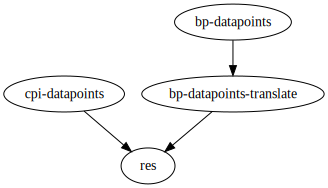

In [9]:
# also in graph

chef.to_graph()

In [10]:
# to run the recipe and get the output:

res = chef.run()

In [11]:
res

[<ProcedureResult: res>]

In [12]:
res[0].get_data().keys()

dict_keys(['biofuels_production_kboed', 'biofuels_production_ktoe', 'carbon_dioxide_emissions', 'coal_consumption_mtoe', 'coal_production_mtoe', 'coal_production_tonnes', 'electricity_generation', 'gas_consumption_bcf', 'gas_consumption_bcm', 'gas_consumption_tonnes', 'gas_production_bcf', 'gas_production_bcm', 'gas_production_tonnes', 'gas_proved_reserves_history', 'geo_biomass_other_mtoe', 'geo_biomass_other_twh', 'hydro_consumption_mtoe', 'hydro_consumption_twh', 'nuclear_consumption_mtoe', 'nuclear_consumption_twh', 'oil_consumption_barrels', 'oil_consumption_tonnes', 'oil_production_barrels', 'oil_production_tonnes', 'oil_proved_reserves_history', 'oil_refinery_capacities', 'oil_refinery_throughput', 'other_renewables_mtoe', 'other_renewables_twh', 'primary_energy_consumption', 'solar_consumption_mtoe', 'solar_consumption_twh', 'wind_consumption_mtoe', 'wind_consumption_twh', 'cpi'])

In [16]:
res[0].get_data()['biofuels_production_kboed'].sample(5)

,country,year,biofuels_production_kboed
867,us,1999,54.391
146,canada,2006,3.208
647,thailand,2013,25.129
596,spain,2014,19.836
261,germany,1991,0.000


In [17]:
res[0].get_data()['cpi'].sample(5)

,country,year,cpi
456,solomon_islands,2010,2.80000
146,ken,2014,25.00000
564,dma,2011,5.17456
97,lbr,2014,37.00000
891,isl,2013,78.00000


In [2]:
# we can also create a Chef instance from existing recipes

recipe_file = '../tests/recipes_pass/test_flatten.yml'
print(open(os.path.abspath(recipe_file)).read())

info:
    id: test-flatten


ingredients:
    - id: cme-datapoints
      dataset: ddf--cme
      key: "country,year"
      value: "*"



cooking:
    datapoints:
        - procedure: filter_row
          ingredients:
              - cme-datapoints
          result: filtered
          options:
              filters:
                imr_lower:
                    country: afg
                    year:
                        - 1990
                        - 1991
                imr_upper:
                    country:
                        - usa
                        - swe
                    year:
                        - 1990
                        - 1991
                        - 1992
                        - 1993
                        - 1994
                        - 1995
                        - 1996
        - procedure: flatten
          ingredients:
              - filtered
          options:
              dictionary:
                  "imr*": "{concept}_{country}"
      

In [3]:
chef = Chef.from_recipe(os.path.expandvars(recipe_file),
                        ddf_dir=os.path.expanduser('/Users/semio/src/work/Gapminder/libs/ddf_utils/tests/datasets'))

no serve procedure found, will serve the last result: res


In [4]:
chef.to_recipe()

info:
  id: test-flatten
config:
  ddf_dir: /Users/semio/src/work/Gapminder/libs/ddf_utils/tests/datasets
ingredients:
- id: cme-datapoints
  dataset: ddf--cme
  key: country,year
  values: '*'
cooking:
  datapoints:
  - procedure: filter_row
    ingredients:
    - cme-datapoints
    options:
      filters:
        imr_lower:
          country: afg
          year:
          - 1990
          - 1991
        imr_upper:
          country:
          - usa
          - swe
          year:
          - 1990
          - 1991
          - 1992
          - 1993
          - 1994
          - 1995
          - 1996
    result: filtered
  - procedure: flatten
    ingredients:
    - filtered
    options:
      dictionary:
        imr*: '{concept}_{country}'
      flatten_dimensions:
      - country
    result: res


In [7]:
res = chef.run()

In [8]:
res[0].get_data().keys()

dict_keys(['imr_lower_afg', 'imr_upper_swe', 'imr_upper_usa'])

In [9]:
res[0].get_data()['imr_lower_afg']

,year,imr_lower_afg
29,1990,111.6
30,1991,108.0


# quickly add lots of similar procedures

In [10]:
from ddf_utils.chef.helpers import gen_result_sym

In [11]:
chef = Chef()

In [12]:
chef.add_config(ddf_dir=os.path.expanduser('~/src/work/Gapminder/datasets'))

In [13]:
chef.add_ingredient(id='population_by_age_dps', 
                    dataset='ddf--unpop--wpp_population_semio',
                    key='country_code,year,age',
                    value=['population'])

In [14]:
collection = 'datapoints'


groups = [list(map(str, range(0, 5))),
          list(map(str, range(5, 10))),
          list(map(str, range(10, 20)))
         ]

names = ['population_0_4', 'population_5_9', 'population_10_19']

ingredients_0 = ['population_by_age_dps']

to_merge = []

for g, n in zip(groups, names):
    
    procedure = 'filter_row'
    options = {
        'filters': {
            'population': {
                'age': g}}}
    result = gen_result_sym('filter_row', ingredients_0, options)

        
    chef.add_procedure(collection=collection,
                       procedure=procedure,
                       ingredients=ingredients_0,
                       options=options,
                       result=result
                      )
    
    ingredients = [result]
    procedure = 'groupby'
    options = {
        'groupby': ['country_code', 'year'],
        'aggregate': {'population': 'sum'}
    }
    result = gen_result_sym(procedure, ingredients, options)
    
    chef.add_procedure(collection=collection,
                       procedure=procedure,
                       ingredients=ingredients,
                       options=options,
                       result=result
                      )
    
    ingredients = [result]
    procedure = 'translate_header'
    options = {
        'dictionary': {
            'population': n
        }
    }
    result = gen_result_sym(procedure, ingredients, options)

    chef.add_procedure(collection=collection,
                   procedure=procedure,
                   ingredients=ingredients,
                   options=options,
                   result=result
                  )
    to_merge.append(result)

In [15]:
chef.add_procedure(collection=collection,
                   procedure='merge',
                   ingredients=to_merge,
                   result='result'
                  )

In [16]:
chef.to_recipe()

info: {}
config:
  ddf_dir: /Users/semio/src/work/Gapminder/datasets
ingredients:
- id: population_by_age_dps
  dataset: ddf--unpop--wpp_population_semio
  key: country_code,year,age
  values:
  - population
cooking:
  datapoints:
  - procedure: filter_row
    ingredients: &id001
    - population_by_age_dps
    options:
      filters:
        population:
          age:
          - '0'
          - '1'
          - '2'
          - '3'
          - '4'
    result: filter_bda72b
  - procedure: groupby
    ingredients:
    - filter_bda72b
    options:
      groupby:
      - country_code
      - year
      aggregate:
        population: sum
    result: groupby_e34fad
  - procedure: translate_header
    ingredients:
    - groupby_e34fad
    options:
      dictionary:
        population: population_0_4
    result: translate_f5f27b
  - procedure: filter_row
    ingredients: *id001
    options:
      filters:
        population:
          age:
          - '5'
          - '6'
          - '7'
      

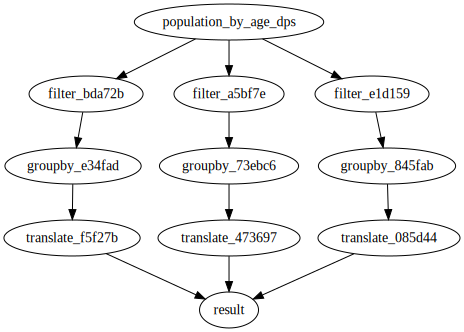

In [17]:
chef.to_graph()

In [18]:
res = chef.run()

In [19]:
res

[<ProcedureResult: result>]

In [20]:
res[0].get_data().keys()

dict_keys(['population_0_4', 'population_5_9', 'population_10_19'])

# Error handling

In [21]:
chef = Chef()

In [22]:
i = '''
id: cpi-datapoints
dataset: ddf--transpint--corrupton
key: country, year
value: "*"
snieot: 'soneot'
'''

d = yaml.round_trip_load(i)
chef.add_ingredient(**d)

no ddf_dir in config, assuming current working dir


In [23]:
i = '''
id: cpi-datapoints_
dataset: ddf--transpint--corrupton
oh_my_interesting_key: country, year   # error
value: "*"
'''

d = yaml.round_trip_load(i)

try:
    chef.add_ingredient(**d)
except KeyError as e:
    print(str(e))

no ddf_dir in config, assuming current working dir


'Field "key" is mandatory. Please provide this field in the options.'


In [24]:
i = '''
procedure: my_new_procedure
ingredients:
    - testing
options:
    opt: val
result: result
'''

d = yaml.round_trip_load(i)
chef.add_procedure('datapoints', **d)

# Advance usage: create new procedure

will add description later

In [25]:
from ddf_utils.chef.ingredient import Ingredient, ProcedureResult

In [26]:
def multiply_1000(dag, ingredients, result, **options):
    ingredients = [dag.get_node(x) for x in ingredients]
    ingredient = ingredients[0].evaluate()
    
    new_data = dict()
    for k, df in ingredient.get_data().items():
        df_ = df.copy()
        df_[k] = df_[k] * 1000
        new_data[k] = df_
        
    return ProcedureResult(result, ingredient.key, new_data)

In [27]:
chef = Chef()
chef.add_config(ddf_dir=os.path.expanduser('~/src/work/Gapminder/datasets'))

In [28]:
i = '''
id: cpi-datapoints
dataset: ddf--transpint--corrupton
key: country, year
value: "*"
'''

d = yaml.round_trip_load(i)
chef.add_ingredient(**d)

In [29]:
chef.register_procedure(multiply_1000)

In [31]:
chef.add_procedure(collection='datapoints',
                   procedure='multiply_1000',
                   result='res',
                   ingredients=['cpi-datapoints']
                  )

In [32]:
res = chef.run()

In [33]:
res[0].get_data()['cpi'].head(5)

,country,year,cpi
0,dnk,2014,92000.0
1,nzl,2014,91000.0
2,fin,2014,89000.0
3,swe,2014,87000.0
4,nor,2014,86000.0


In [34]:
chef.ingredients

[<Ingredient: cpi-datapoints>]

In [35]:
chef.ingredients[0].get_data()['cpi'].head()  # the original

,country,year,cpi
0,dnk,2014,92.0
1,nzl,2014,91.0
2,fin,2014,89.0
3,swe,2014,87.0
4,nor,2014,86.0


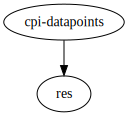

In [36]:
chef.to_graph()